# Sudoku Solver

**Prepared by:** William Bartel (wbartel@nd.edu, 2024) and Andrew Brooks (abrooks7@nd.edu, 2024)

Nonlinear and Stochastic Optimization - Project 2

# Learning Objectives
* Understanding the generation of random sudoku puzzles
* Learning how to formulate sudokus as an optimization problem
* Computing average time to solve $n\times n$ sudokus
* Learning how to make graph visualizations

# Imports

In [ ]:
# This code cell installs packages on Colab

import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.easy_install()
    helper.install_glpk()
else:
    sys.path.insert(0, '../')
    import helper
helper.set_plotting_style()

# Import Libraries
import pyomo.environ as pyo
import pandas as pd
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from itertools import product
import time as timeTool
import csv
from typing import KeysView
from IPython.display import Image, display


--2024-12-14 01:29:36--  https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6493 (6.3K) [text/plain]
Saving to: ‘helper.py.2’

helper.py.2         100%[===================>]   6.34K  --.-KB/s    in 0s      

2024-12-14 01:29:36 (55.4 MB/s) - ‘helper.py.2’ saved [6493/6493]

idaes was found! No need to install.
Installing glpk via apt-get...


# Defining Sudoku Puzzles


Sudoku puzzles are one of the most widely known logical puzzles. The rules of a sudoku puzzle are simple. For an $n$ x $n$ puzzle, each row, each column, and each subsquare must have exactly one of each number 1 through $n$. One can look at the numbers given in the puzzle and use logic to conclude which squares must contain which numbers. An example puzzle is shown below.

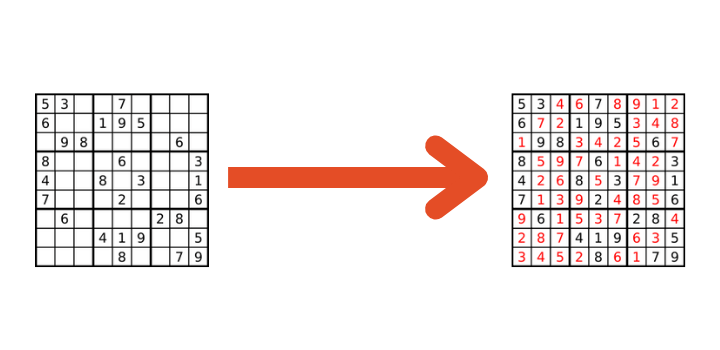

### Formulating an Optimization Problem for $n\times n$ Puzzle




**Sets:** \\
Rows $R=\{0,1, ...,n\}$ \\
Columns $C=\{0,1, ...,n\}$ \\
Values $V=\{0,1, ...,n\}$ \\
Subgrids $K=\{0,1, ...,n\}$

**Parameters:** \\
$s_{v,i,j} = $ is value $v$ present in box located at $(i,j)$ from unsolved puzzle for $i\in R, j\in C, v \in V$. (Binary) \\
$SG_{i} = $ coordinate pairs for the boxes in each subgrid for $i\in K$ \\

**Variables:** \\
$y_{v,i,j} = $ is value $v$ present in box located at $(i,j)$ when creating solved puzzle for $i\in R, j\in C, v \in V$. (Binary)


**Objective:** \\
$\min0$

**Constraints:**

$$\sum_{i\in R}y_{v,i,j}=1, \forall j\in C, v\in V$$
$$\sum_{j\in C}y_{i,j,k}=1, \forall i\in R, v\in V$$
$$\sum_{(i,j)\in SG[\ l \ ]}y_{v,i,j}=1, \forall l\in K$$
$$\sum_{v\in V}y_{v,i,j}=1, \forall i\in R, j\in C$$
$$y_{v,i,j} * s_{v,i,j} = s_{v,i,j}, \forall i\in R, j\in C, v\in V$$

Because the problem is a feasibility problem and there is only one possible answer, no objective is needed and thus the objective is a constant, in this case 0.

The constraints are described as follows: \\
Constraint 1: There can only be one instance of each possible value in each row.
Constraint 2: There can only be one instance of each possible value in each column.
Constraint 3: There can only be one instance of each possible value in each subgrid.
Constraint 4: There can only be one value in each square.
Constraint 5: Each value given by the unsolved puzzle must be the same in the solved puzzle.

In [ ]:
# Define class 'Puzzle' to store an unsolved or solved sudoku board
# Stores size of puzzle, grid values, and subgrid coordinates

class Puzzle:
  def __init__(self, board):

    n = len(board[0])
    l = int(math.sqrt(n))

    # n = number of rows = number of columns
    self.size = n

    self.grid = board

    s = {}

    for v in range(1, n + 1):
        for r in range(1, n + 1):
            for c in range(1, n + 1):
                # Access board elements safely
                if board[r - 1][c - 1] == v:
                    s[(v, r, c)] = 1
                else:
                    s[(v, r, c)] = 0

    # s[(v,r,c)] = 1 if the cell in position (r,c) has value v
    # s[(v,r,c)] = 0 otherwise
    # Note: rows and columns begin at 1 and end at n
    self.params = s

    subgrids = dict();

    for i in range(1,n+1):
     subgrids[i] = [(r,c) for r in range(1+l*((i-1)%l),1+l*((i-1)%l + 1)) for c in range(1+l*int(math.floor((i-1)/l)),1+l*int(math.floor((i-1)/l) + 1)) ]

    # subgrids[i] = collection of ordered pairs (r,c) such that (r,c) is in the i-th subgrid
    # subgrids are sqrt(n) by sqrt(n) grids and are indexed left to right, then top to bottom
    self.subgrids = subgrids

# Generating Sudoku Datasets



To generate random sudoku puzzles, we developed a method. First, we stored a solved sudoku puzzle for $n=4,9,16,25,36$ as a starting point for developing a random sudoku puzzle. Next, to develop a random solved sudoku puzzle, we randomly scrambled the rows and columns of the initial puzzle.

Selecting two random columns that pass through the same subgrids, we can interchange the columns while preserving the rules of a solved sudoku. We can similarly permute rows that pass through the same subgrids. Additionally, we can select $\sqrt{n}$ columns that all pass through the same subgrids and interchange them with $\sqrt{n}$ columns that all pass through the same (but different than the first) subgrids.

## Random Sudoku Generator

In [ ]:
# Define initial solved sudoku puzzles of sizes 4,9,16,25,36
# These puzzles will be scrambled to generate random puzzles

initial_puzzles = []

initial_puzzles.append(Puzzle([
    [1, 2, 3, 4],
    [3, 4, 1, 2],
    [4, 1, 2, 3],
    [2, 3, 4, 1]
]))

initial_puzzles.append(Puzzle([
    [5, 3, 4, 6, 7, 8, 9, 1, 2],
    [6, 7, 2, 1, 9, 5, 3, 4, 8],
    [1, 9, 8, 3, 4, 2, 5, 6, 7],
    [8, 5, 9, 7, 6, 1, 4, 2, 3],
    [4, 2, 6, 8, 5, 3, 7, 9, 1],
    [7, 1, 3, 9, 2, 4, 8, 5, 6],
    [9, 6, 1, 5, 3, 7, 2, 8, 4],
    [2, 8, 7, 4, 1, 9, 6, 3, 5],
    [3, 4, 5, 2, 8, 6, 1, 7, 9]
]))

initial_puzzles.append(Puzzle([
    [5, 7, 12, 3, 9, 11, 14, 10, 1, 15, 13, 2, 8, 6, 16, 4],
    [1, 9, 11, 15, 2, 3, 13, 12, 6, 8, 16, 4, 14, 10, 7, 5],
    [6, 10, 14, 16, 4, 8, 5, 1, 11, 3, 7, 12, 15, 9, 2, 13],
    [4, 8, 2, 13, 16, 7, 6, 15, 14, 10, 5, 9, 3, 1, 11, 12],
    [11, 15, 10, 12, 3, 2, 16, 13, 7, 6, 9, 8, 5, 4, 1, 14],
    [16, 14, 9, 7, 12, 1, 11, 6, 15, 2, 4, 5, 10, 8, 13, 3],
    [8, 2, 3, 4, 15, 5, 10, 7, 16, 1, 14, 13, 11, 12, 6, 9],
    [13, 1, 6, 5, 14, 9, 4, 8, 12, 11, 10, 3, 16, 7, 15, 2],
    [15, 11, 5, 2, 10, 14, 12, 9, 13, 4, 1, 16, 7, 3, 8, 6],
    [12, 6, 7, 9, 13, 16, 8, 3, 5, 14, 11, 10, 1, 2, 4, 15],
    [14, 3, 13, 1, 6, 4, 7, 11, 8, 9, 2, 15, 12, 5, 10, 16],
    [10, 4, 16, 8, 5, 15, 1, 2, 3, 12, 6, 7, 9, 13, 14, 11],
    [9, 12, 8, 10, 7, 6, 3, 4, 2, 16, 15, 11, 13, 14, 5, 1],
    [7, 16, 15, 6, 1, 12, 9, 5, 4, 13, 8, 14, 2, 11, 3, 10],
    [2, 13, 1, 11, 8, 10, 15, 14, 9, 5, 3, 6, 4, 16, 12, 7],
    [3, 5, 4, 14, 11, 13, 2, 16, 10, 7, 12, 1, 6, 15, 9, 8],
]))

initial_puzzles.append(Puzzle([
    [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],
    [11,12,13,14,15,1,2,3,4,5,16,17,18,19,20,22,23,21,24,25,6,7,8,9,10],
    [6,7,8,9,10,24,25,22,21,23,1,2,3,4,5,11,12,13,14,15,16,17,18,19,20],
    [23,22,21,25,24,16,17,18,19,20,6,7,8,9,10,1,2,3,4,5,11,12,13,14,15],
    [16,17,18,19,20,11,12,13,14,15,24,21,23,22,25,6,7,8,9,10,1,2,3,4,5],
    [3,1,5,2,14,19,16,20,7,11,18,15,21,24,23,8,10,25,22,12,4,9,17,13,6],
    [4,8,10,6,18,3,1,23,24,2,13,22,25,12,14,9,16,19,11,17,5,15,20,21,7],
    [24,15,25,7,12,4,5,9,13,6,3,1,16,17,2,18,20,14,21,23,8,10,22,11,19],
    [9,19,11,20,21,8,22,25,17,14,4,5,10,7,6,3,1,15,13,2,18,24,16,12,23],
    [13,23,17,22,16,10,15,21,18,12,8,9,20,11,19,4,5,24,7,6,3,1,14,25,2],
    [2,5,1,15,3,14,13,17,25,8,23,16,19,10,18,12,24,11,20,9,7,4,21,6,22],
    [7,16,6,11,4,2,18,1,5,3,12,24,17,8,22,14,21,23,10,13,20,25,19,15,9],
    [12,25,23,21,8,7,4,6,11,9,2,20,1,5,3,17,15,22,18,19,14,13,24,10,16],
    [14,20,19,24,9,22,23,10,16,21,7,4,6,15,13,2,25,1,5,3,12,8,11,17,18],
    [17,10,22,18,13,12,24,15,20,19,14,25,11,21,9,7,4,6,8,16,2,23,1,5,3],
    [19,6,4,1,2,25,21,11,12,24,20,18,9,23,8,15,14,16,17,22,10,5,7,3,13],
    [5,13,9,3,7,17,8,2,1,4,22,19,24,25,11,10,18,20,23,21,15,6,12,16,14],
    [15,18,20,23,17,5,6,7,3,16,10,14,2,1,4,19,13,9,12,24,22,21,25,8,11],
    [22,14,12,16,11,18,10,19,15,13,5,6,7,3,21,25,8,2,1,4,17,20,9,23,24],
    [10,21,24,8,25,20,9,14,23,22,15,13,12,16,17,5,6,7,3,11,19,18,2,1,4],
    [18,3,2,5,1,15,20,4,8,25,17,10,22,13,24,23,11,12,16,14,9,19,6,7,21],
    [25,4,7,13,6,9,3,16,2,1,19,23,14,20,12,21,22,10,15,8,24,11,5,18,17],
    [20,11,15,12,19,23,14,5,6,7,21,3,4,2,1,24,9,17,25,18,13,16,10,22,8],
    [8,9,16,17,22,21,19,24,10,18,25,11,5,6,7,13,3,4,2,1,23,14,15,20,12],
    [21,24,14,10,23,13,11,12,22,17,9,8,15,18,16,20,19,5,6,7,25,3,4,2,1]
]))


initial_puzzles.append(Puzzle([
    [31, 32, 33, 34, 35, 36, 25, 26, 27, 28, 29, 30, 19, 20, 21, 22, 23, 24, 13, 14, 15, 16, 17, 18, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6],
    [1, 2, 3, 4, 5, 6, 31, 32, 33, 34, 35, 36, 25, 26, 27, 28, 29, 30, 19, 20, 21, 22, 23, 24, 13, 14, 15, 16, 17, 18, 7, 8, 9, 10, 11, 12],
    [7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 31, 32, 33, 34, 35, 36, 25, 26, 27, 28, 29, 30, 19, 20, 21, 22, 23, 24, 13, 14, 15, 16, 17, 18],
    [13, 14, 15, 16, 17, 18, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 31, 32, 33, 34, 35, 36, 25, 26, 27, 28, 29, 30, 19, 20, 21, 22, 23, 24],
    [19, 20, 21, 22, 23, 24, 13, 14, 15, 16, 17, 18, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 31, 32, 33, 34, 35, 36, 25, 26, 27, 28, 29, 30],
    [25, 26, 27, 28, 29, 30, 19, 20, 21, 22, 23, 24, 13, 14, 15, 16, 17, 18, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 31, 32, 33, 34, 35, 36],
    [32, 33, 34, 35, 36, 1, 26, 27, 28, 29, 30, 31, 20, 21, 22, 23, 24, 25, 14, 15, 16, 17, 18, 19, 8, 9, 10, 11, 12, 13, 2, 3, 4, 5, 6, 7],
    [2, 3, 4, 5, 6, 7, 32, 33, 34, 35, 36, 1, 26, 27, 28, 29, 30, 31, 20, 21, 22, 23, 24, 25, 14, 15, 16, 17, 18, 19, 8, 9, 10, 11, 12, 13],
    [8, 9, 10, 11, 12, 13, 2, 3, 4, 5, 6, 7, 32, 33, 34, 35, 36, 1, 26, 27, 28, 29, 30, 31, 20, 21, 22, 23, 24, 25, 14, 15, 16, 17, 18, 19],
    [14, 15, 16, 17, 18, 19, 8, 9, 10, 11, 12, 13, 2, 3, 4, 5, 6, 7, 32, 33, 34, 35, 36, 1, 26, 27, 28, 29, 30, 31, 20, 21, 22, 23, 24, 25],
    [20, 21, 22, 23, 24, 25, 14, 15, 16, 17, 18, 19, 8, 9, 10, 11, 12, 13, 2, 3, 4, 5, 6, 7, 32, 33, 34, 35, 36, 1, 26, 27, 28, 29, 30, 31],
    [26, 27, 28, 29, 30, 31, 20, 21, 22, 23, 24, 25, 14, 15, 16, 17, 18, 19, 8, 9, 10, 11, 12, 13, 2, 3, 4, 5, 6, 7, 32, 33, 34, 35, 36, 1],
    [33, 34, 35, 36, 1, 2, 27, 28, 29, 30, 31, 32, 21, 22, 23, 24, 25, 26, 15, 16, 17, 18, 19, 20, 9, 10, 11, 12, 13, 14, 3, 4, 5, 6, 7, 8],
    [3, 4, 5, 6, 7, 8, 33, 34, 35, 36, 1, 2, 27, 28, 29, 30, 31, 32, 21, 22, 23, 24, 25, 26, 15, 16, 17, 18, 19, 20, 9, 10, 11, 12, 13, 14],
    [9, 10, 11, 12, 13, 14, 3, 4, 5, 6, 7, 8, 33, 34, 35, 36, 1, 2, 27, 28, 29, 30, 31, 32, 21, 22, 23, 24, 25, 26, 15, 16, 17, 18, 19, 20],
    [15, 16, 17, 18, 19, 20, 9, 10, 11, 12, 13, 14, 3, 4, 5, 6, 7, 8, 33, 34, 35, 36, 1, 2, 27, 28, 29, 30, 31, 32, 21, 22, 23, 24, 25, 26],
    [21, 22, 23, 24, 25, 26, 15, 16, 17, 18, 19, 20, 9, 10, 11, 12, 13, 14, 3, 4, 5, 6, 7, 8, 33, 34, 35, 36, 1, 2, 27, 28, 29, 30, 31, 32],
    [27, 28, 29, 30, 31, 32, 21, 22, 23, 24, 25, 26, 15, 16, 17, 18, 19, 20, 9, 10, 11, 12, 13, 14, 3, 4, 5, 6, 7, 8, 33, 34, 35, 36, 1, 2],
    [34, 35, 36, 1, 2, 3, 28, 29, 30, 31, 32, 33, 22, 23, 24, 25, 26, 27, 16, 17, 18, 19, 20, 21, 10, 11, 12, 13, 14, 15, 4, 5, 6, 7, 8, 9],
    [4, 5, 6, 7, 8, 9, 34, 35, 36, 1, 2, 3, 28, 29, 30, 31, 32, 33, 22, 23, 24, 25, 26, 27, 16, 17, 18, 19, 20, 21, 10, 11, 12, 13, 14, 15],
    [10, 11, 12, 13, 14, 15, 4, 5, 6, 7, 8, 9, 34, 35, 36, 1, 2, 3, 28, 29, 30, 31, 32, 33, 22, 23, 24, 25, 26, 27, 16, 17, 18, 19, 20, 21],
    [16, 17, 18, 19, 20, 21, 10, 11, 12, 13, 14, 15, 4, 5, 6, 7, 8, 9, 34, 35, 36, 1, 2, 3, 28, 29, 30, 31, 32, 33, 22, 23, 24, 25, 26, 27],
    [22, 23, 24, 25, 26, 27, 16, 17, 18, 19, 20, 21, 10, 11, 12, 13, 14, 15, 4, 5, 6, 7, 8, 9, 34, 35, 36, 1, 2, 3, 28, 29, 30, 31, 32, 33],
    [28, 29, 30, 31, 32, 33, 22, 23, 24, 25, 26, 27, 16, 17, 18, 19, 20, 21, 10, 11, 12, 13, 14, 15, 4, 5, 6, 7, 8, 9, 34, 35, 36, 1, 2, 3],
    [35, 36, 1, 2, 3, 4, 29, 30, 31, 32, 33, 34, 23, 24, 25, 26, 27, 28, 17, 18, 19, 20, 21, 22, 11, 12, 13, 14, 15, 16, 5, 6, 7, 8, 9, 10],
    [5, 6, 7, 8, 9, 10, 35, 36, 1, 2, 3, 4, 29, 30, 31, 32, 33, 34, 23, 24, 25, 26, 27, 28, 17, 18, 19, 20, 21, 22, 11, 12, 13, 14, 15, 16],
    [11, 12, 13, 14, 15, 16, 5, 6, 7, 8, 9, 10, 35, 36, 1, 2, 3, 4, 29, 30, 31, 32, 33, 34, 23, 24, 25, 26, 27, 28, 17, 18, 19, 20, 21, 22],
    [17, 18, 19, 20, 21, 22, 11, 12, 13, 14, 15, 16, 5, 6, 7, 8, 9, 10, 35, 36, 1, 2, 3, 4, 29, 30, 31, 32, 33, 34, 23, 24, 25, 26, 27, 28],
    [23, 24, 25, 26, 27, 28, 17, 18, 19, 20, 21, 22, 11, 12, 13, 14, 15, 16, 5, 6, 7, 8, 9, 10, 35, 36, 1, 2, 3, 4, 29, 30, 31, 32, 33, 34],
    [29, 30, 31, 32, 33, 34, 23, 24, 25, 26, 27, 28, 17, 18, 19, 20, 21, 22, 11, 12, 13, 14, 15, 16, 5, 6, 7, 8, 9, 10, 35, 36, 1, 2, 3, 4],
    [36, 1, 2, 3, 4, 5, 30, 31, 32, 33, 34, 35, 24, 25, 26, 27, 28, 29, 18, 19, 20, 21, 22, 23, 12, 13, 14, 15, 16, 17, 6, 7, 8, 9, 10, 11],
    [6, 7, 8, 9, 10, 11, 36, 1, 2, 3, 4, 5, 30, 31, 32, 33, 34, 35, 24, 25, 26, 27, 28, 29, 18, 19, 20, 21, 22, 23, 12, 13, 14, 15, 16, 17],
    [12, 13, 14, 15, 16, 17, 6, 7, 8, 9, 10, 11, 36, 1, 2, 3, 4, 5, 30, 31, 32, 33, 34, 35, 24, 25, 26, 27, 28, 29, 18, 19, 20, 21, 22, 23],
    [18, 19, 20, 21, 22, 23, 12, 13, 14, 15, 16, 17, 6, 7, 8, 9, 10, 11, 36, 1, 2, 3, 4, 5, 30, 31, 32, 33, 34, 35, 24, 25, 26, 27, 28, 29],
    [24, 25, 26, 27, 28, 29, 18, 19, 20, 21, 22, 23, 12, 13, 14, 15, 16, 17, 6, 7, 8, 9, 10, 11, 36, 1, 2, 3, 4, 5, 30, 31, 32, 33, 34, 35],
    [30, 31, 32, 33, 34, 35, 24, 25, 26, 27, 28, 29, 18, 19, 20, 21, 22, 23, 12, 13, 14, 15, 16, 17, 6, 7, 8, 9, 10, 11, 36, 1, 2, 3, 4, 5]
]))

The scramble_cols function, for instance, swaps two random columns that pass through the same subgrids.

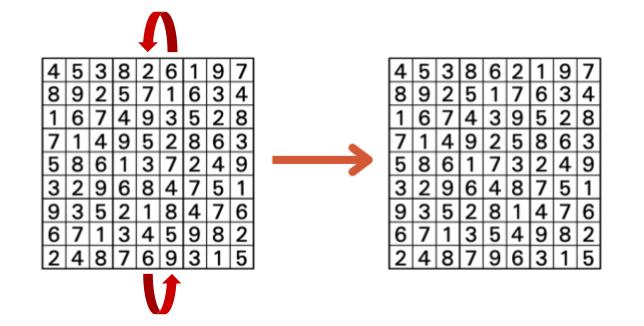

In [ ]:
# Scrambling algorithms to create a random solved sudoku
# Random selection of squares are selected to be deleted to form
# an unsolved sudoku puzzle

def scramble_rows(puzzle,n):
  a = random.randint(0,n-1)
  b = random.randint(0,n-1)
  c = random.randint(0,n-1)
  while c == b:
    c = random.randint(0,n-1)
  temp = puzzle[a*n + b]
  puzzle[a*n + b] = puzzle[a*n + c]
  puzzle[a*n + c] = temp
  return puzzle

def swap_row_groups(puzzle,n):
  a = random.randint(0,n-1)
  b = random.randint(0,n-1)
  while a == b:
    b = random.randint(0,n-1)
  for i in range(0,n):
    temp = puzzle[a*n+i]
    puzzle[a*n+i] = puzzle[b*n+i]
    puzzle[b*n+i] = temp
  return puzzle

def scramble_cols(puzzle,n):
  a = random.randint(0,n-1)
  b = random.randint(0,n-1)
  c = random.randint(0,n-1)
  while c == b:
    c = random.randint(0,n-1)
  temp = []
  for i in range(0,n**2):
    temp.append(puzzle[i][a*n+b])
  for i in range(0,n**2):
    puzzle[i][a*n+b] = puzzle[i][a*n+c]
    puzzle[i][a*n+c] = temp[i]
  return puzzle

def swap_col_groups(puzzle,n):
  a = random.randint(0,n-1)
  b = random.randint(0,n-1)
  while a == b:
    b = random.randint(0,n-1)
  for i in range(0,n):
    temp = []
    for j in range(0,n**2):
      temp.append(puzzle[j][a*n+i])
      puzzle[j][a*n+i] = puzzle[j][b*n+i]
      puzzle[j][b*n+i] = temp[j]
  return puzzle

def scramble_puzzle(puzzle,n):

  # k = number of scrambles to perform to sudoku board
  k = random.randint(1000,1100)

  for i in range(0,k):
    d = random.randint(0,5)
    if d == 0:
      puzzle = swap_col_groups(puzzle,n)
    elif d == 1:
      puzzle = swap_row_groups(puzzle,n)
    elif d <= 3:
      puzzle = scramble_rows(puzzle,n)
    else:
      puzzle = scramble_cols(puzzle,n)
  return puzzle

def generate_puzzle(puzzle,size):

    # Converts solved puzzle to unsolved puzzle by converting squares to blank squares
    # Number of squares to convert into blanks depends on size of puzzle
    if size == 4:
      blanks = random.randint(7,9)
    elif size == 9:
      blanks = random.randint(31,45)
    elif size == 16:
      blanks = random.randint(90,120)
    elif size == 25:
      blanks = random.randint(226,275)
    elif size == 36:
      blanks = random.randint(450,500)
    else:
      raise ValueError("Ineligible Puzzle Size")

    blank_positions = random.sample(list(product(range(size), range(size))), blanks)

    for row, col in blank_positions:
        puzzle[row][col] = 0
    return puzzle

## Sudoku Writer and Reader Functions

The writer/reader functions are designed to transfer sudoku puzzle data to and from a CSV file. The writer creates a file 'sudoku_puzzles_n.csv' where $n$ is the side length of the puzzles generated (for instance, $n=4,9,16,\ldots$). Each row stores a puzzle.

The reader converts the CSV file back to Puzzle objects, reading one row at a time.

In [ ]:
# Writes randomly generated sudoku puzzles to CSV file
# File is named 'sudoku_puzzles_n.csv' where n = size of the puzzle
# Default configuration writes 100 randomly generated files
# to CSV file for sizes 4,9,16,25,36

def generate_puzzles(start_puzzle, num_puzzles=100):
    puzzles = []
    for _ in range(num_puzzles):
        # Make a copy of the puzzle
        puzzle = [row[:] for row in start_puzzle.grid]
        scrambled_puzzle = scramble_puzzle(puzzle,int(math.sqrt(start_puzzle.size)))
        puzzle_with_blanks = generate_puzzle(scrambled_puzzle,start_puzzle.size)
        puzzles.append(puzzle_with_blanks)
    return puzzles

def write_puzzles_to_csv(puzzles, filename):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        for puzzle in puzzles:
            # Flatten the puzzle to write as a single row in the CSV file
            writer.writerow([cell for row in puzzle for cell in row])

for i in range(0,len(initial_puzzles)):

  # Generate 100 puzzles, this number can be modified
  puzzles = generate_puzzles(initial_puzzles[i], num_puzzles=100)

  # Write the puzzles to a CSV file
  write_puzzles_to_csv(puzzles, filename=f'sudoku_puzzles_{(i+2)**2}.csv')

In [ ]:
# Interpreter that reads puzzles from CSV file
# Function is passed the puzzle size and file name

def read_puzzle_from_csv(size=9,filename='sudoku_puzzles_9.csv', line_number=0):
    with open(filename, mode='r') as file:
        reader = csv.reader(file)

        # Read all lines into a list

        lines = list(reader)

        # Get the specified line (line_number) and convert it back to a grid

        line = lines[line_number]

        # Convert the list back to a grid
        puzzle = [list(map(int, line[i:i+size])) for i in range(0, len(line), size)]

        return puzzle

# Example use of read_puzzle_from_csv
# Reads the first puzzle from the 9 by 9 CSV file and prints it
puzzle = read_puzzle_from_csv()
print(puzzle)

[[0, 7, 0, 0, 0, 0, 2, 3, 4], [0, 8, 4, 6, 2, 0, 0, 1, 0], [9, 0, 1, 0, 0, 3, 0, 6, 7], [1, 9, 7, 3, 5, 4, 6, 2, 0], [2, 4, 0, 9, 1, 6, 7, 5, 3], [0, 5, 0, 2, 7, 8, 9, 0, 0], [8, 6, 0, 0, 0, 1, 4, 9, 0], [7, 1, 0, 4, 0, 2, 3, 0, 0], [0, 3, 2, 0, 9, 0, 1, 0, 6]]


# Sudoku Optimization Solver


Below is the optimization formulation to solve a sudoku puzzle. The formulation was described earlier.

In [ ]:
# Optimization solver

def sudokuSolver(puzzle, solver, printer):

  model = pyo.ConcreteModel()

  n = puzzle.size
  subgridSize = int(math.sqrt(n))

  # Define sets
  # V = values, R = rows, C = columns, K = subgrid indices
  V = range(1,n+1)
  R = range(1,n+1)
  C = range(1,n+1)
  K = range(1,n+1)

  s = puzzle.params
  subgrids = puzzle.subgrids

  # Define decision variable y
  # Determines values to fill blank squares
  model.y = pyo.Var(V,R,C, within=pyo.Binary, initialize = 0)

  # One value per row
  def row_con(m,v,r):
      return sum(m.y[v,r,c] for c in C) == 1;
  model.row_con = pyo.Constraint(V,R, rule = row_con);

  # One value per col
  def col_con(m,v,c):
      return sum(m.y[v,r,c] for r in R) == 1;
  model.col_con = pyo.Constraint(V,C, rule = col_con);

  # One value per cell
  def val_con(m,r,c):
      return sum(m.y[v,r,c] for v in V) == 1;
  model.val_con = pyo.Constraint(R,C, rule = val_con);

  # Values equal params
  def param_con(m,v,r,c):
      return m.y[v,r,c]*s[v,r,c] == s[v,r,c];
  model.param_con = pyo.Constraint(V,R,C, rule = param_con);

  # One value per subgrid
  def subgrid_con(m,v,k):
      return sum(m.y[v,r,c] for (r,c) in subgrids[k]) == 1;
  model.subgrid_con = pyo.Constraint(V,K, rule = subgrid_con);

  # No objective
  model.obj = pyo.Objective(expr=0);

  # Solve the model
  solver = SolverFactory(solver);
  solver.solve(model,tee=False);

  # Print solution
  if printer == True:
    unsolvedSudokuPrinter(puzzle);
    solvedSudokuPrinter(model, puzzle);

The printer functions below are designed to print sudoku puzzles in a readable format. The unsolved sudoku puzzle printer prints a sudoku puzzle with the given squares, leaving blank squares where values are not given. The solved sudoku printer prints the unsolved sudoku puzzle with red solution values printed in the blank squares.

In [ ]:
# Sudoku puzzle printer
# unsolvedSudokuPrinter prints the unsolved sudoku puzzle
# solvedSudokuPrinter prints the solved sudoku puzzle

def unsolvedSudokuPrinter(puzzle):
    fig, ax = plt.subplots()
    n = puzzle.size
    ax.matshow(np.zeros((n, n)), cmap="Blues", vmin=0, vmax=1)

    s = puzzle.params

    # Add the numbers to each cell
    for i in range(1,n+1):
      for j in range(1,n+1):
        for k in range(1,n+1):
          if s[i,j,k] != 0:
            ax.text(k-1, j-1, str(i), va='center', ha='center')

    # Draw the grid lines
    for i in range(n+1):
        lw = 2 if i % math.sqrt(puzzle.size) == 0 else 1
        ax.axhline(i - 0.5, color="black", linewidth=lw)
        ax.axvline(i - 0.5, color="black", linewidth=lw)

    ax.axis('off')
    plt.show()

def solvedSudokuPrinter(model, puzzle):
    fig, ax = plt.subplots()
    n = puzzle.size
    ax.matshow(np.zeros((n, n)), cmap="Blues", vmin=0, vmax=1)

    s = puzzle.params

    # Add the numbers to each cell
    for i in range(1,n+1):
      for j in range(1,n+1):
        for k in range(1,n+1):
          if value(model.y[i, j, k]) != 0:
            if s[i,j,k] != 0:
              ax.text(k-1, j-1, str(i), va='center', ha='center', color='black')
            else:
              ax.text(k-1, j-1, str(i), va='center', ha='center', color='red')

    # Draw the grid lines
    for i in range(n+1):
        lw = 2 if i % math.sqrt(puzzle.size) == 0 else 1
        ax.axhline(i - 0.5, color="black", linewidth=lw)
        ax.axvline(i - 0.5, color="black", linewidth=lw)

    ax.axis('off')
    plt.show()

Example of 9 by 9 Sudoku:


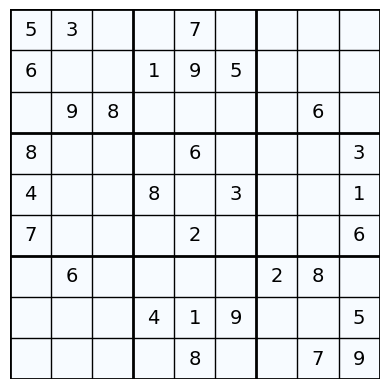

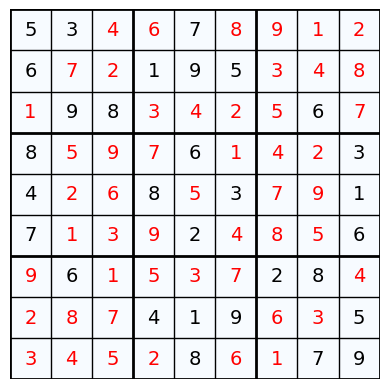


Example of 4 by 4 Sudoku:


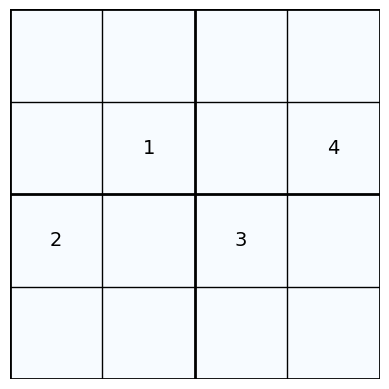

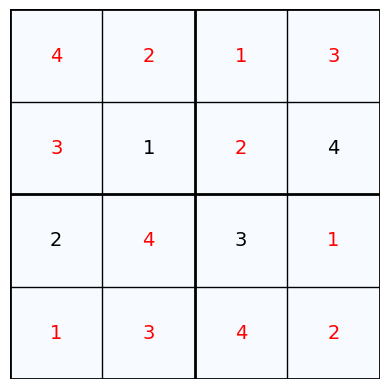

In [ ]:
# Example use of solver and printer

print('Example of 9 by 9 Sudoku:')
exampleSudoku = Puzzle([
    [5, 3, 0, 0, 7, 0, 0, 0, 0],
    [6, 0, 0, 1, 9, 5, 0, 0, 0],
    [0, 9, 8, 0, 0, 0, 0, 6, 0],
    [8, 0, 0, 0, 6, 0, 0, 0, 3],
    [4, 0, 0, 8, 0, 3, 0, 0, 1],
    [7, 0, 0, 0, 2, 0, 0, 0, 6],
    [0, 6, 0, 0, 0, 0, 2, 8, 0],
    [0, 0, 0, 4, 1, 9, 0, 0, 5],
    [0, 0, 0, 0, 8, 0, 0, 7, 9]
])

sudokuSolver(exampleSudoku, 'glpk', True)

print()
print('Example of 4 by 4 Sudoku:')

exampleSudoku2 = Puzzle([
    [0, 0, 0, 0],
    [0, 1, 0, 4],
    [2, 0, 3, 0],
    [0, 0, 0, 0]
])

sudokuSolver(exampleSudoku2, 'glpk', True)

# Computing Average Sudoku Solve Times

For a given positive integer $a\geq2$, let $n=a^2$. We are curious how the complexity of solving an $n\times n$ sudoku scales. It is fair to hypothesize that the complexity scales at a superlinear rate, given that the number of cells in an $n\times n$ sudoku is $n^2=a^4$.

Our goal is to test two solvers (glpk and cbc) to determine which solver, if any, is fastest at solving sudokus. The following program reads through the CSV files generated earlier, reading the first 4 lines. The number of lines read can be modified, but it is set to 4 by default for a quick computation time.

We test the average solve time for an $n\times n$ sudoku for $a=2,3,4,5,6$. Again, this list can be modified, as ommitting $a=6$ improves computation time. We use the 'time' import to compute the average solve time, and we output the results.

In [121]:
# Computes average time to solve sudoku of given size

# Set iterations to a number from 1 to the number of generated puzzles in CSV file (by default can go up to 100)
# Determines how many puzzles to look at to compute average solve time
# Expect up to 3-5 minute runtime for iterations = 100, sizes = [4,9,16,25]
iterations = 10

# Can add 36 to the list of sizes
sizes = [4,9,16,25]
solvers = ['glpk','cbc']

# List to store values for regression analysis
results = []

for solver in solvers:
  averages = []

  print("For the solver "+solver+":")
  print()

  for size in sizes:

    for i in range(0,iterations):
      times = []
      puzzle = read_puzzle_from_csv(size,filename=f'sudoku_puzzles_{size}.csv',line_number=i)
      sudoku = Puzzle(puzzle)

      # Time import measures time to solve sudoku
      start_time = timeTool.time()
      sudokuSolver(sudoku,solver, False)
      end_time = timeTool.time()

      times.append(end_time-start_time)

    averages.append(sum(times)/float(iterations))
    print(f"Average Time for {size} by {size} Sudoku: {sum(times)/float(iterations)}")

  print()
  results.append(averages)

For the solver glpk:

Average Time for 4 by 4 Sudoku: 0.001663351058959961
Average Time for 9 by 9 Sudoku: 0.007821965217590331
Average Time for 16 by 16 Sudoku: 0.02681698799133301
Average Time for 25 by 25 Sudoku: 0.13296031951904297

For the solver cbc:

Average Time for 4 by 4 Sudoku: 0.003746366500854492
Average Time for 9 by 9 Sudoku: 0.008947992324829101
Average Time for 16 by 16 Sudoku: 0.03517723083496094
Average Time for 25 by 25 Sudoku: 0.12167906761169434



The following code graphs the data collected from computing the average solve time. After running this multiple times across many datasets, computing a cubic, quartic, or exponential regression on the data often yields about $R^2>0.97$, suggesting that one of these regressions would fit the data. More datapoints would be needed to determine the exact fit. However, computing average solve times for $a=7,8,...$ becomes more and more computationally intensive.

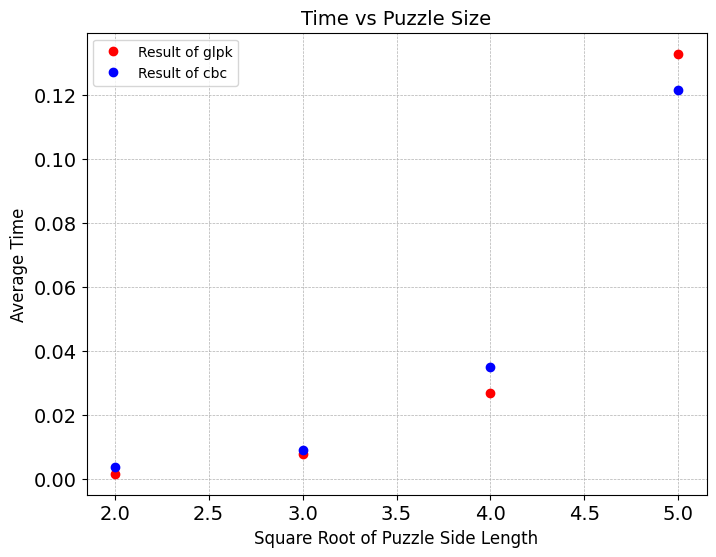

In [122]:
# Graphs the data for average puzzle solve time based on puzzle size

# Calculate square roots of puzzle side lengths
sqrt_sizes = [math.sqrt(size) for size in sizes]

# Create the plot
plt.figure(figsize=(8, 6))

colors = ['r','b','g']

for i in range(0,len(results)):
  plt.plot(sqrt_sizes, results[i], marker='o',linestyle='', color=colors[i], label=f'Result of {solvers[i]}')

# Add labels and title
plt.xlabel('Square Root of Puzzle Side Length', fontsize=12)
plt.ylabel('Average Time', fontsize=12)
plt.title('Time vs Puzzle Size', fontsize=14)

# Add a grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=10)

# Show the plot
plt.show()

The results show glpk and cbc are relatively the same for solving puzzles with $n=4,9,16,25,36$. After testing the solvers on multiple datasets, glpk seems slightly faster than cbc, especially on smaller puzzles. For $n=4,9,16$, the sudoku problems are relatively simple and solve time is in fractions of a second, so this could be explained by the fact that glpk is a simpler model than cbc. cbc often works better for more complex models.

## Conclusion


We implemented the sudoku solver as described as a template for Project 2: we formulated a sudoku puzzle as an optimization problem, built a function to print solutions, and we analyzed how scaling the sudoku size impacts the average time it takes to solve a puzzle. We expaned upon these requirements, adding a function to randomly generate a dataset of puzzles and functions to read/write these puzzles to CSV files.

There are a couple of limitations of our implementations. First, a more robust random sudoku generator could be created. Our algorithm for generating random puzzles does not ensure that the puzzle has a unique solution. A backtracking algorithm that ensures the solution is unique could be implemented, but we found this to take too much time. A select number of puzzles could also be generated that require different solving techniques, testing the limits of each solver.

A second limitation is that it takes too long for colab and our solver to efficiently solve an $n\times n$ puzzle for $n\geq49$. This could be solved by finding ways to improve the efficiency in our algorithms or to use a faster computer/compiler.

Despite these limitations, we were able to create an effective sudoku puzzle generator and solver that prints solutions. Furthermore, we tested to show there is likely a superlinear relationship between problem size and solver time.